In [1]:
import math
import numpy as np
from scipy import integrate
from scipy.stats import norm
from matplotlib import pyplot as plt
import random
import concurrent.futures
import os
import pickle

%matplotlib inline
tau = 2 * math.pi
pi = math.pi
random.seed(666)

import profiles as P

with open("naca0012.dat", "r") as f:
    x, y = np.loadtxt(f, dtype = float, delimiter="\t", unpack = True)

freestream_4 = P.Freestream(u_inf = 1, alpha = 4)

NACA0012 = P.Profile(x,y)
NACA0012.get_aero(freestream_4)
NACA0012.get_limitations()
NACA0012.get_aero(freestream_4)
NACA0012.get_limitations()

In [2]:
with (open("gen1", "rb")) as pkl:
    gen1 = pickle.load(pkl)

In [3]:
len(gen1)

100

In [4]:
def inner_penalty_function(profile):
    if profile.roughness < 2:
        return profile.roughness
    else:
        return (profile.roughness-2)**2

CL_NACA0012 = NACA0012.cl
shadow_NACA0012 = NACA0012.shadow
r = 0.1

def abc_penalty_function(profile, gen: int, c: float, a: float, b: float, penalty_function: callable):
    return (c*gen)**a * inner_penalty_function(profile)**b

def general_objective_function(profile,  A: callable, B: callable, penalty_function: callable):
    fitness = A(profile.cl / CL_NACA0012) / B(profile.shadow / shadow_NACA0012) - penalty_function(profile)
    if fitness > 0:
        return fitness
    else:
        return 0
    
def objective_function_0(profile):
    return general_objective_function(profile, lambda x: x, lambda x: x, inner_penalty_function)
    
def objective_function_shadow_squared(profile):
    return general_objective_function(profile, lambda x: x, lambda x: x**2, inner_penalty_function)
    
def objective_function_shadow_tangens(profile):
    return general_objective_function(profile, lambda x: x, lambda x: np.tan, inner_penalty_function)

def objective_function_penalty_abc(profile, gen: int, c: float, a: float, b: float, inner_penalty_function: callable = inner_penalty_function):
    def penalty(profile):
        return abc_penalty_function(profile, gen = gen, c = c, a = a, b = b, penalty_function = inner_penalty_function)
    return general_objective_function(profile, lambda x: x, lambda x: x**2, penalty)

In [5]:
def mutate(p, mu_range = [0, 1], d_range = [-4, 4]):
    """
    mutates a given profile by denting
    mu - allowed range of dent's centre
    d - amplitude for the dent, scaled by NACA0012's vertical shadow
    """
    mu = random.uniform(mu_range[0], mu_range[1])
    d = random.uniform(d_range[0], d_range[1]) * shadow_NACA0012
    p.dent(mu, d)
    p.get_aero(freestream_4)
    p.get_limitations()
    
def chance_mutate(p, mu_range = [0, 1], d_range = [-4, 4], prob = 0.5):
    """
    has a prob probability of mutating profile p. default prob = 1/2
    """
    if random.uniform(0, 1) < prob:
        mutate(p, mu_range, d_range)
    print(f"mutated {p.ID}")
    
def make_children(P, mu_range = [0, 1], d_range = [-4, 4], prob = 0.5, n = 10):
    def fun(P):
        return chance_mutate(P, mu_range = mu_range, d_range = d_range, prob = prob)
    children = []
    for i in range(n):
        children.append(P.copy())
    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(fun, children) 
    print(f"***Finished children of {P.ID}***")
    return children

In [6]:
def roulette_wheel_selection(profiles):
    """
    returns ID of profile winning roulette wheel selection out of the given pool
    """
    total_fitness = sum([p.fitness for p in profiles])
    pick = random.uniform(0, total_fitness)
    current = 0
    for profile in profiles:
        current += profile.fitness
        if current > pick:
            return profile.ID

def crossover(p1, p2, k = None):
    """
    returns a profile crossed from 2 parents (front and back half)
    the slicing is random across the chord, unless specified (k=None)
    """
    x_1, y_1 = p1.x, p1.y
    x_2, y_2 = p2.x, p2.y
    N = len(x_1)

    if not k:
        k = random.uniform(0, 1)
    
    for i, x in enumerate(x_1):
        if x <= k:
            a = i
            b = N - 2 * a
            break
            
    x_upper_back = p1.x[:a]
    x_front = p2.x[a:a + b]
    x_lower_back = p1.x[a + b:]
    y_upper_back = p1.y[:a]
    y_front = p2.y[a:a + b]
    y_lower_back = p1.y[a + b:]
    x = np.concatenate((x_upper_back, x_front, x_lower_back))
    y = np.concatenate((y_upper_back, y_front, y_lower_back))
    return  P.Profile(x, y)

def roulette_crossover(profiles, k = None):
    """
    returns an offspring profile created by crossing 2 specimen in a given generation, using roulette selecting
    """
    p1_ID = roulette_wheel_selection(profiles)
    p2_ID = roulette_wheel_selection([p for p in profiles if p.ID != p1_ID])
    p1 = [p for p in profiles if p.ID == p1_ID ][0]
    p2 = [p for p in profiles if p.ID == p2_ID ][0]
    offspring = crossover(p1, p2, k = k)
    offspring.get_aero(freestream_4)
    offspring.get_limitations()
    return offspring

In [7]:
def create_offspring(profiles, mu_range = [0, 1], d_range = [-4, 4], prob = 0.5, n = 100):
    def fun(P):
        return chance_mutate(P, mu_range, d_range, prob)
    children = []
    for i in range(n):
        children.append(roulette_crossover(profiles))
    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(fun, children)
    print(f"***Finished creating offspring***")
    return children   

In [8]:
for p in gen1:
    p.fitness = objective_function_penalty_abc(p, gen = 1, c = 0.25, a = 2, b = 2)
    print(p.fitness, p.ID)

0.9374999999999996 6306
0.9377335648921061 6307
0.9878248234662099 6308
0.9374999999999996 6309
0.9920276462844619 6310
1.0496461384716367 6311
1.0580577460900131 6312
0.9374999999999996 6313
0.9230616308652245 6314
0.8153694954355509 6315
0.9988762423311202 6316
0.9374999999999996 6317
0.8160038997299797 6318
0.9715118712082509 6319
0.9374999999999996 6320
0.9161043302866945 6321
0.9374999999999996 6322
0.9374999999999996 6323
0.9374999999999996 6324
0.878074848363169 6325
0.8715399536189617 6326
1.1075826990438695 6327
1.2458297791592703 6328
0.9407266886550174 6329
0.9238998701212099 6330
0.9090387514983856 6331
0.9594486917046912 6332
0.9374999999999996 6333
0.9374999999999996 6334
0.9388410842441448 6335
0.8957890562909687 6336
0.9374999999999996 6337
0.9374999999999996 6338
0.9350267604356913 6339
0.9230545525549833 6340
0.9385852902491749 6341
0.8889646278364574 6342
0.9374999999999996 6343
0.9374999999999996 6344
0.9374999999999996 6345
0.9374999999999996 6346
0.937499999999999

In [9]:
generations = [gen1]
for i in range(20):
    generations.append(create_offspring(generations[-1], d_range = [-0.01, 0.01], n = 1000, prob = 0.1))
    for p in generations[-1]:
        p.fitness = objective_function_penalty_abc(p, gen = i + 2, c = 0.25, a = 2, b = 2)

mutated 2
mutated 3
mutated 4
mutated 5
mutated 6
mutated 7
mutated 8
mutated 9
mutated 10
mutated 11
mutated 12
mutated 13
mutated 14
mutated 16
mutated 17
mutated 18
mutated 19
mutated 20
mutated 21
mutated 22
mutated 23
mutated 24
mutated 25
mutated 26
mutated 27
mutated 28
mutated 29
mutated 30
mutated 31
mutated 32
mutated 33
mutated 15
mutated 35
mutated 36
mutated 38
mutated 39
mutated 40
mutated 41
mutated 42
mutated 43
mutated 44
mutated 45
mutated 46
mutated 48
mutated 49
mutated 51
mutated 55
mutated 56
mutated 57
mutated 58
mutated 59
mutated 60
mutated 61
mutated 62
mutated 63
mutated 64
mutated 65
mutated 66
mutated 67
mutated 68
mutated 69
mutated 70
mutated 72
mutated 34
mutated 73
mutated 75
mutated 76
mutated 78
mutated 37
mutated 80
mutated 81
mutated 53
mutated 54
mutated 71
mutated 50
mutated 84
mutated 85
mutated 86
mutated 87
mutated 90
mutated 91
mutated 92
mutated 93
mutated 47
mutated 52
mutated 74
mutated 94
mutated 95
mutated 96
mutated 97
mutated 98
mutated

222998484.47133017 0
142900844.35745013 0.11889003593473729
ID of best solution: 19597


[1.2639386603097562,
 4.516596658429615,
 4.356644352128142,
 5.768106130458097,
 5.4293267081951155]

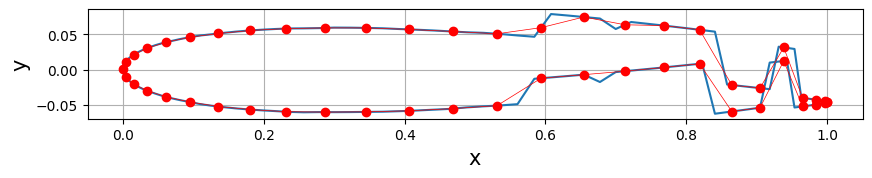

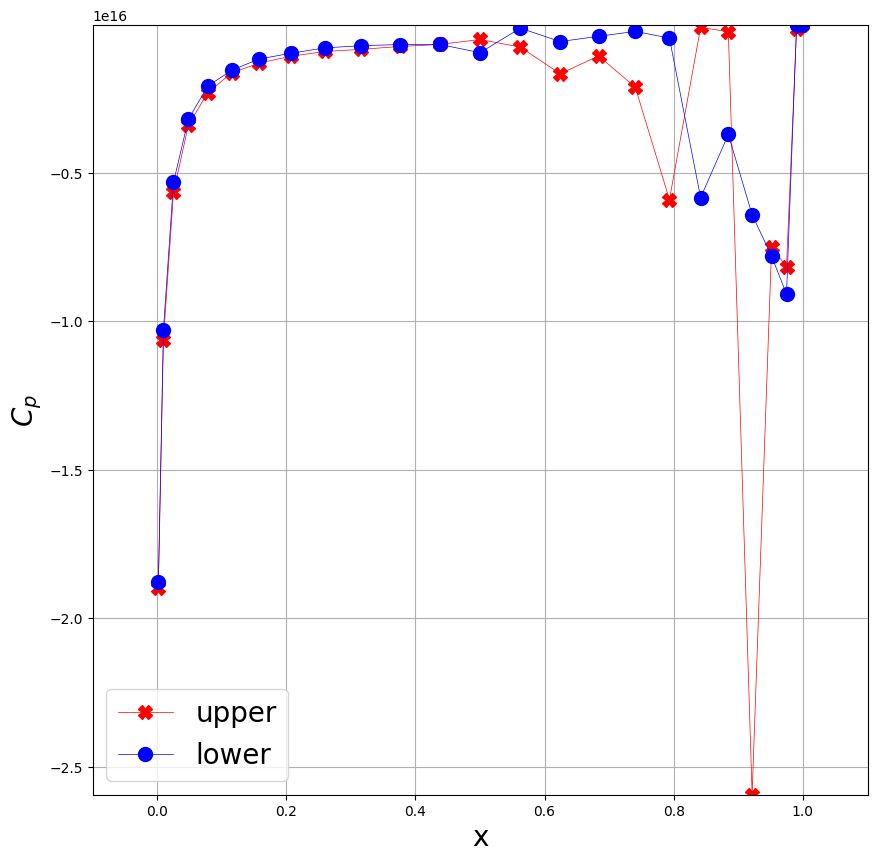

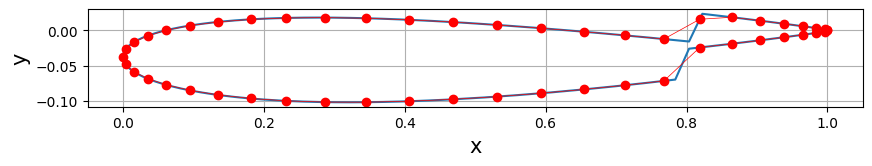

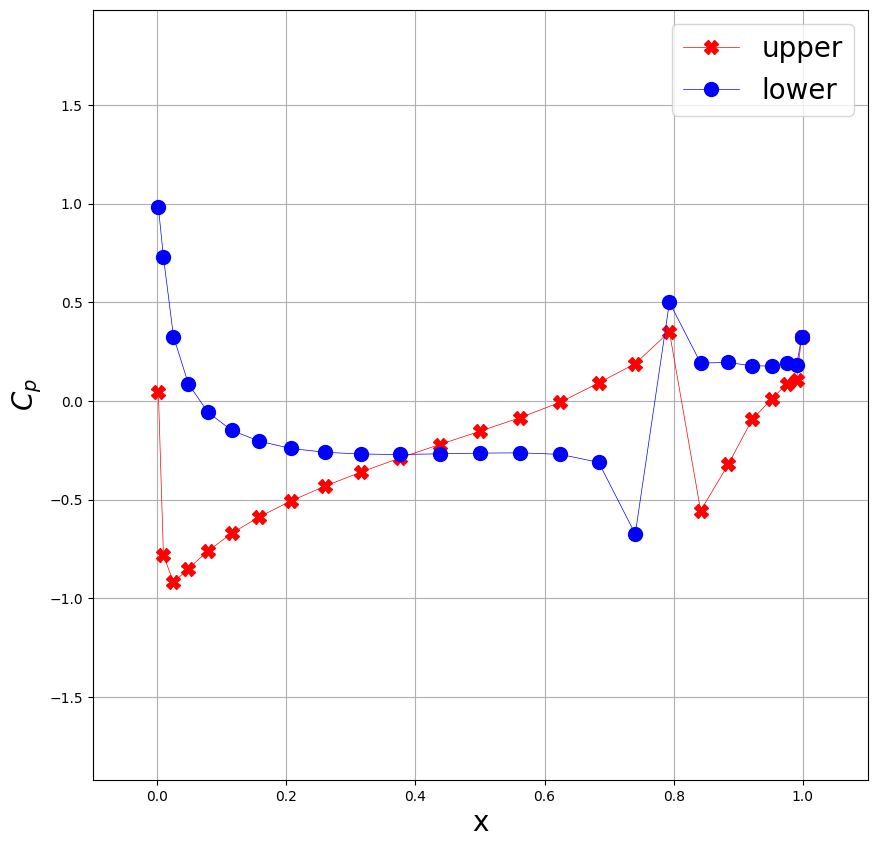

In [10]:
bests = []
worsts = []
for gen in generations:
    bests.append(max(gen, key = lambda x: x.fitness))
    worsts.append(min(gen, key = lambda x: x.fitness))
best = max(bests, key = lambda x: x.fitness)
worst = min(worsts, key = lambda x: x.fitness)
print(best.fitness, worst.fitness)
print(best.cl, worst.cl)
best.draw()
best.draw_cp()
worst.draw()
worst.draw_cp()
print(f"ID of best solution: {best.ID}")
[best.fitness for best in bests][:5]

In [12]:
with open("generations_c025a2b2", "wb") as pkl:
    pickle.dump(generations, pkl, protocol = pickle.HIGHEST_PROTOCOL)

In [13]:
with (open("generations_c025a2b2", "rb")) as pkl:
    generations = pickle.load(pkl)

MemoryError: 

In [24]:
avg_fitness = []
max_fitness = []
for i, gen in enumerate(generations):
    if i < 60:
        avg = 0
        maxi = 0
        for p in gen:
            avg += p.fitness
            maxi = max([maxi, p.fitness])
        avg = avg / len(gen)
        avg_fitness.append((avg, i+1))
        max_fitness.append((maxi, i+1))

In [25]:
avg_fitness_smooth = []
max_fitness_smooth = []
for i, gen in enumerate(generations):
    if i < 60:
        avg = 0
        maxi = 0
        k = 0
        for p in gen:
            if p.roughness < 3:
                avg += p.fitness
                maxi = max([maxi, p.fitness])
                k += 1
        if k != 0:
            avg = avg / k
        else:
            avg = 0
        avg_fitness_smooth.append((avg, i+1))
        max_fitness_smooth.append((maxi, i+1))

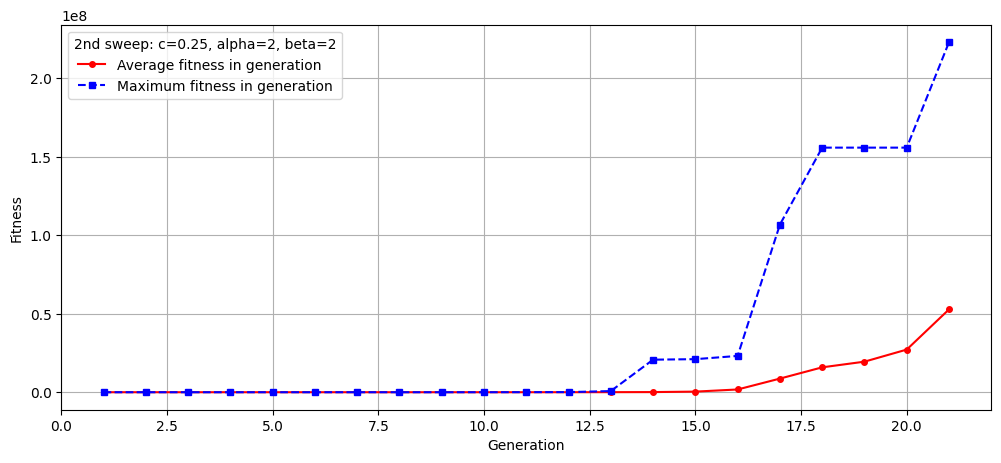

In [26]:
plt.figure(figsize=(12,5))
ytmp, xtmp = zip(*avg_fitness)
plt.plot(xtmp, ytmp, color = "red", marker = "o", markersize = "4", linestyle = "solid")
ytmp, xtmp = zip(*max_fitness)
plt.plot(xtmp, ytmp, color = "blue", marker = "s", markersize = "4", linestyle = "dashed")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.grid("True")
plt.legend(["Average fitness in generation", "Maximum fitness in generation"],
          title = "2nd sweep: c=0.25, alpha=2, beta=2")

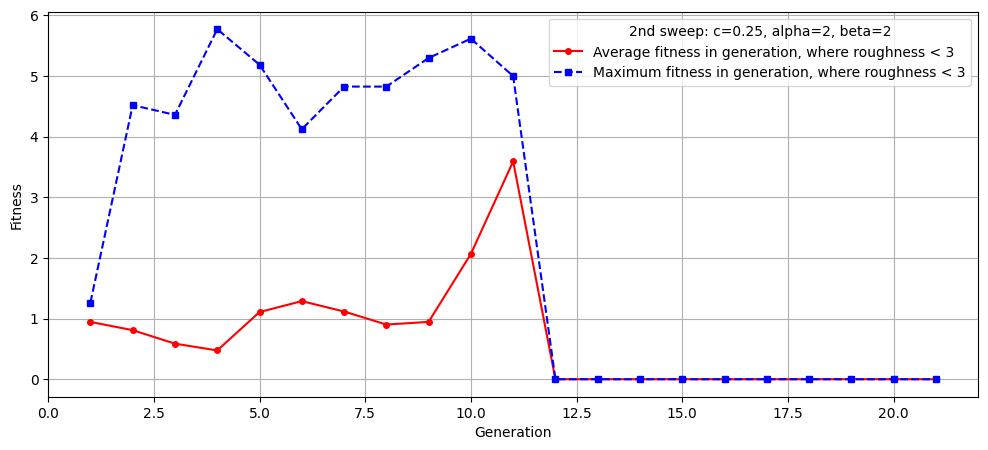

In [27]:
plt.figure(figsize=(12,5))
ytmp, xtmp = zip(*avg_fitness_smooth)
plt.plot(xtmp, ytmp, color = "red", marker = "o", markersize = "4", linestyle = "solid")
ytmp, xtmp = zip(*max_fitness_smooth)
plt.plot(xtmp, ytmp, color = "blue", marker = "s", markersize = "4", linestyle = "dashed")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.grid("True")
plt.legend(["Average fitness in generation, where roughness < 3", "Maximum fitness in generation, where roughness < 3"],
          title = "2nd sweep: c=0.25, alpha=2, beta=2")

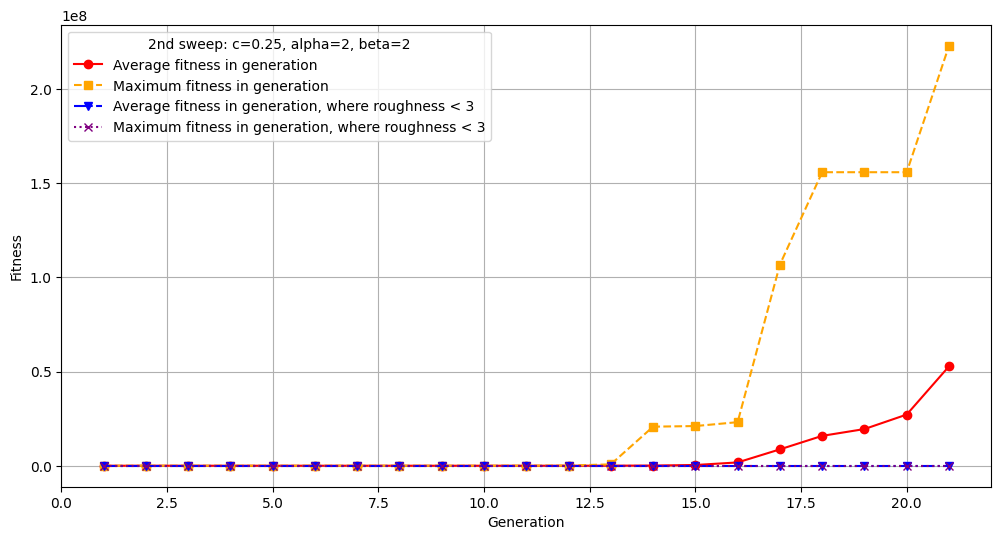

In [28]:
plt.figure(figsize=(12,6))
ytmp, xtmp = zip(*avg_fitness)
plt.plot(xtmp, ytmp, color = "red", marker = "o", markersize = "6", linestyle = "solid")
ytmp, xtmp = zip(*max_fitness)
plt.plot(xtmp, ytmp, color = "orange", marker = "s", markersize = "6", linestyle = "dashed")
ytmp, xtmp = zip(*avg_fitness_smooth)
plt.plot(xtmp, ytmp, color = "blue", marker = "v", markersize = "6", linestyle = "dashdot")
ytmp, xtmp = zip(*max_fitness_smooth)
plt.plot(xtmp, ytmp, color = "purple", marker = "x", markersize = "6", linestyle = "dotted")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.grid("True")
plt.legend(["Average fitness in generation", "Maximum fitness in generation",
            "Average fitness in generation, where roughness < 3", "Maximum fitness in generation, where roughness < 3"],
          title = "2nd sweep: c=0.25, alpha=2, beta=2")

In [29]:
bests = []
for gen in generations:
    bests.append(max(gen, key = lambda x: x.fitness))
best = max(bests, key = lambda x: x.fitness)

bests_constrained = []
for gen in generations:
    try:
        bests_constrained.append(max([p for p in gen if p.roughness < 3], key = lambda x: x.fitness))
    except:
        pass
best_constrained = max(bests_constrained, key = lambda x: x.fitness)

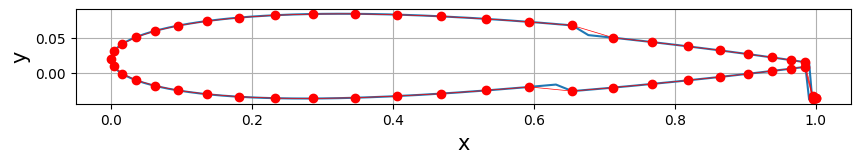

In [30]:
best_constrained.draw()

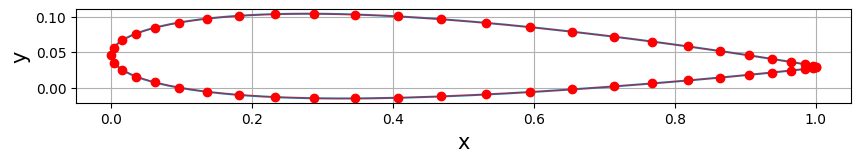

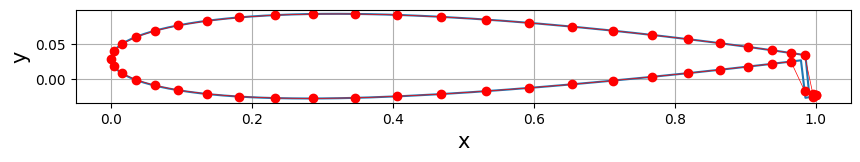

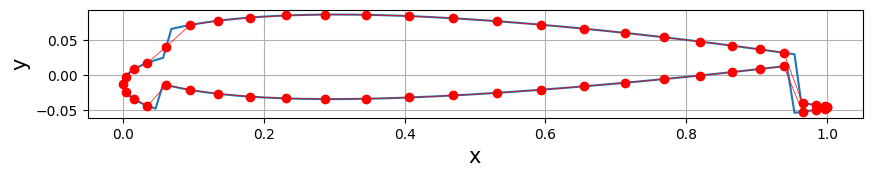

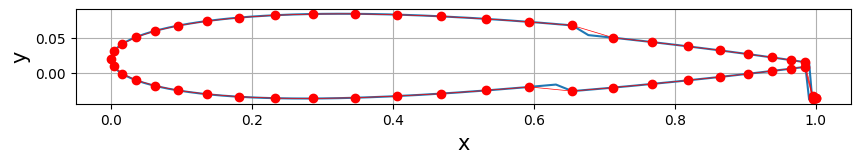

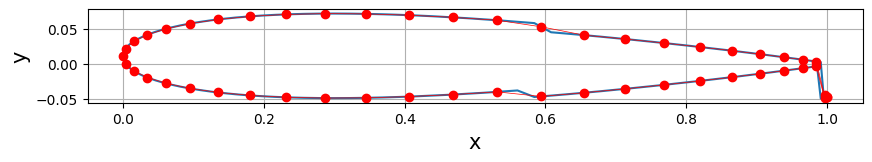

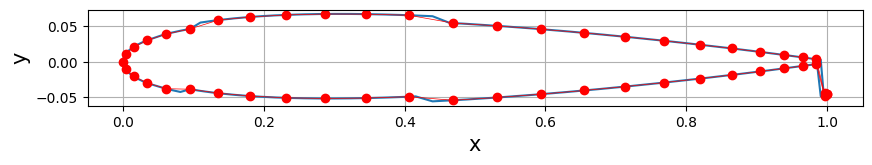

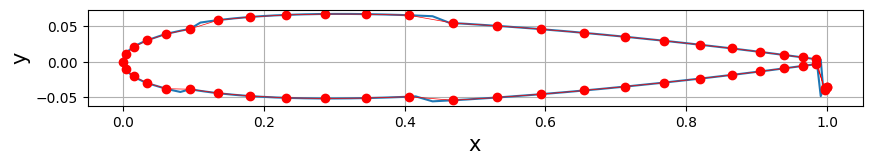

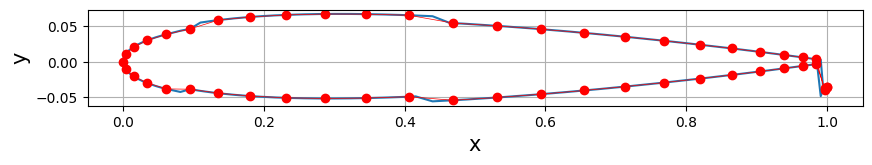

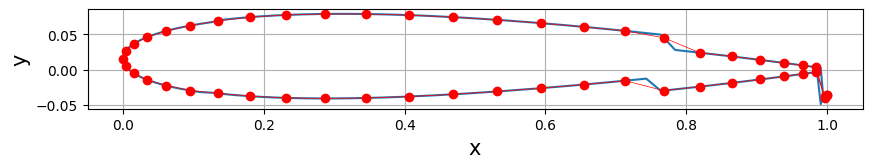

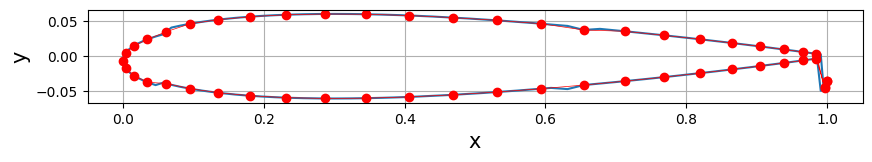

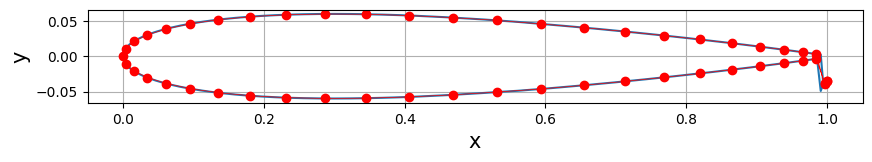

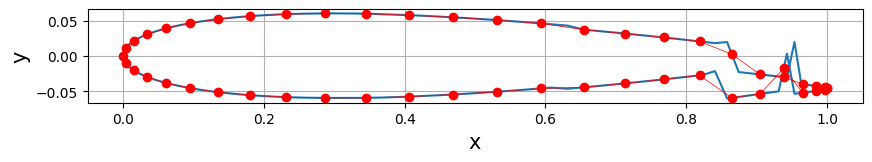

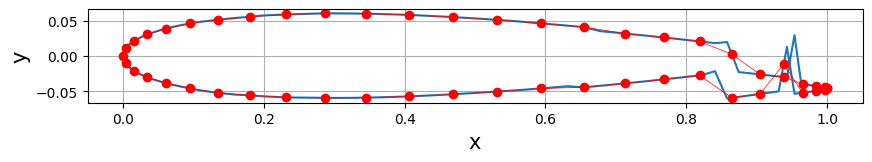

In [31]:
for p in bests_constrained:
    p.draw()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


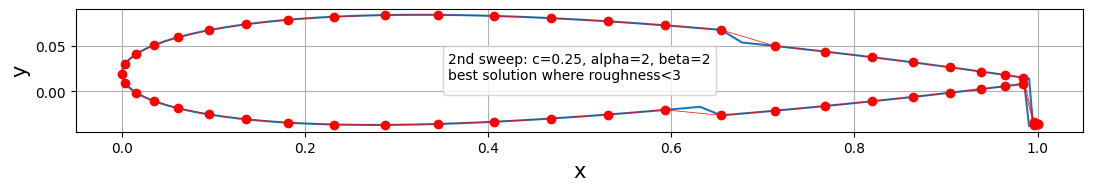

In [32]:
def custom_draw(P, description = None, width = 13, height = 13):
    panels = P.panels
    x = P.x
    y = P.y
    
    
    plt.figure(figsize = (width, height))
    plt.grid()
    plt.xlabel("x", fontsize = 15)
    plt.ylabel("y", fontsize = 15)
    plt.plot(x, y)
    plt.axis("scaled")
    # plt.xlim(0.92, 1.01)
    # plt.ylim(-0.05, 0.02)
    plt.plot(np.append([panel.x_a for panel in panels], panels[0].x_a),
     np.append([panel.y_a for panel in panels], panels[0].y_a),
    marker = "o", color = "red", linewidth = 0.5)
    plt.legend(
          title = description)

custom_draw(best_constrained, "2nd sweep: c=0.25, alpha=2, beta=2\nbest solution where roughness<3")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


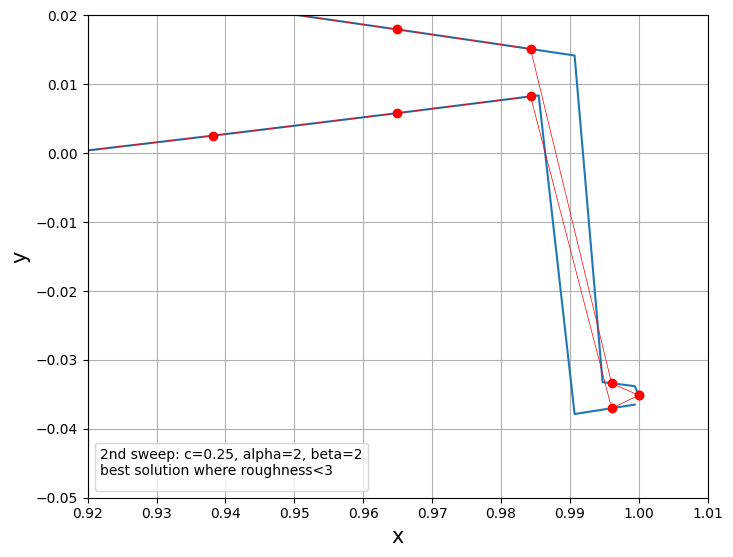

In [33]:
def custom_draw(P, description = None, width = 8, height = 8):
    panels = P.panels
    x = P.x
    y = P.y
    
    
    plt.figure(figsize = (width, height))
    plt.grid()
    plt.xlabel("x", fontsize = 15)
    plt.ylabel("y", fontsize = 15)
    plt.plot(x, y)
    plt.axis("scaled")
    plt.xlim(0.92, 1.01)
    plt.ylim(-0.05, 0.02)
    plt.plot(np.append([panel.x_a for panel in panels], panels[0].x_a),
     np.append([panel.y_a for panel in panels], panels[0].y_a),
    marker = "o", color = "red", linewidth = 0.5)
    plt.legend(
          title = description)

custom_draw(best_constrained, "2nd sweep: c=0.25, alpha=2, beta=2\nbest solution where roughness<3")